In [2]:
%matplotlib inline
from common_imports import *

In [3]:
H = W = 10
grid = np.zeros((H, W))
# use diagnoal.
# pos_list = [(0,0), (1,1), (2,2), (3,3), (4,4), (5,5), (6,6), (7,7), (8,8)]
# use all.
pos_list = []
for h in range(0, H, 2):
    for w in range(0, W, 2):
        if (h, w) == (H-1, W-1):
            continue
        pos_list.append((w, h))

tasks = [GridWorldFixedStart(pos, grid=grid, action_stoch=0.2, goal={(H-1, W-1): 1.}, rewards={(H-1, W-1): 1.,}, wall_penalty=0., gamma=0.9)
         for pos in pos_list]
random.shuffle(tasks)

test_pos_list = [(0,0), (3,3), (6,6), (8,8)]
test_tasks = [GridWorldFixedStart(pos, grid=grid, action_stoch=0.2, goal={(H-1, W-1): 1.}, rewards={(H-1, W-1): 1.,}, wall_penalty=0., gamma=0.9)
         for pos in test_pos_list]
task0 = tasks[0]

In [4]:
# create the task.
state_shape = task0.state_shape
task = task0
# define potential neural network architectures.
def two_layer(states):
    '''
    two layer neural network with same number of hidden units.
    '''
    state_vecs = states.flatten(2)
    return arch.two_layer(state_vecs, np.prod(task.state_shape), 128, task.num_actions)

def conv_net(states):
    '''
    conv+max-pool layer first followed by a fully-connected layer.
    '''
    conv1 = Conv(input_dim=state_shape[0], output_dim=32, filter_size=(2,2), pool_size=(2,2), activation='relu')
    h1 = conv1(states)
    h1_dim = int((state_shape[1]-2+1)/2) * int((state_shape[2]-2+1)/2) * 32
    h1 = h1.flatten(2)
    fc1 = FullyConnected(input_dim=h1_dim, output_dim=32, activation='relu')
    h2 = fc1(h1)
    linear_layer = FullyConnected(input_dim=32, output_dim=task.num_actions, activation=None)
    output = linear_layer(h2)
    return (output, {
        'conv1': conv1,
        'fc1': fc1
    })



# meta-feature extractors.

In [5]:
def mf_xy(task):
    return np.array([task.start_pos[0], task.start_pos[1]])

def kernel_func(task_i, task_j):
    feat_i = mf_xy(task_i)
    feat_j = mf_xy(task_j)
    return np.exp(1 - 1 * np.sum(np.abs(feat_i - feat_j)))

# Train and Eval funcs

In [15]:
dqn = DQN(task0, arch_func=two_layer, state_type=T.tensor4)

In [16]:
learner = DeepQlearn(dqn, gamma=0.9, lr=1e-3, memory_size = 1000, epsilon=0.1)
budget = 5
tol=1e-4
train_func = lambda task:  learner.run(task, num_episodes = 10, tol=tol, budget=budget)
# eval_func = lambda policy, task: reward_stochastic(policy, task, gamma=tol**(1. / budget), num_trials=100, tol=tol)
eval_func = lambda policy, task: qval_stochastic(policy, task, gamma=0.9, budget=budget, num_trials=100, tol=tol)

In [17]:

meta = DQCL.BasicGP(dqn, kernel_func, train_func, eval_func, eta=1/20.)

In [18]:
start_locs = []
ims = []
scores = []
exs = []
for it in range(100):
    meta.run(tasks, num_epochs=1)
    print 'iteration', it
    print 'count'
    pprint(meta.task_count)
    print 'pred'
    pprint(meta.im_pred)
    print 'ucb'
    pprint(meta.im_ucb)
    print 'im_mem'
    pprint(meta.im_mem)
    pprint(meta.diagnostics)
    ims.append(meta.diagnostics['score after'] - meta.diagnostics['score before'])
    start_locs.append(meta.diagnostics['task chosen'].start_pos)
    print '---------------------------------------'
    if (it + 1) % 1 == 0:
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
        
        

iteration 0
count
{(0, 2) -> (9, 9): 1}
pred
{(0, 0) -> (9, 9): 0.0,
 (2, 0) -> (9, 9): 0.0,
 (4, 0) -> (9, 9): 0.0,
 (6, 0) -> (9, 9): 0.0,
 (8, 0) -> (9, 9): 0.0,
 (0, 2) -> (9, 9): 0.0,
 (2, 2) -> (9, 9): 0.0,
 (4, 2) -> (9, 9): 0.0,
 (6, 2) -> (9, 9): 0.0,
 (8, 2) -> (9, 9): 0.0,
 (0, 4) -> (9, 9): 0.0,
 (2, 4) -> (9, 9): 0.0,
 (4, 4) -> (9, 9): 0.0,
 (6, 4) -> (9, 9): 0.0,
 (8, 4) -> (9, 9): 0.0,
 (0, 6) -> (9, 9): 0.0,
 (2, 6) -> (9, 9): 0.0,
 (4, 6) -> (9, 9): 0.0,
 (6, 6) -> (9, 9): 0.0,
 (8, 6) -> (9, 9): 0.0,
 (0, 8) -> (9, 9): 0.0,
 (2, 8) -> (9, 9): 0.0,
 (4, 8) -> (9, 9): 0.0,
 (6, 8) -> (9, 9): 0.0,
 (8, 8) -> (9, 9): 0.0}
ucb
{(0, 0) -> (9, 9): 0.082436063535006418,
 (2, 0) -> (9, 9): 0.082436063535006418,
 (4, 0) -> (9, 9): 0.082436063535006418,
 (6, 0) -> (9, 9): 0.082436063535006418,
 (8, 0) -> (9, 9): 0.082436063535006418,
 (0, 2) -> (9, 9): 0.082436063535006418,
 (2, 2) -> (9, 9): 0.082436063535006418,
 (4, 2) -> (9, 9): 0.082436063535006418,
 (6, 2) -> (9, 9): 0.08

In [ ]:
def plot_scores():
    keys = scores[0].keys()
    xs = exs
    for key in keys:
        ys = [score[key] for score in scores]
        plot(xs, ys)
    legend(keys)
    show()
plot_scores()

## Baseline

In [8]:
task = test_tasks[0]
dqn = DQN(task, arch_func=two_layer, state_type=T.tensor4)
learner = DeepQlearn(dqn, gamma=0.9, lr=1e-3, memory_size = 1280, epsilon=0.1)
scores = []
exs = []
tol = 1e-4
for it in range(10):
    learner.run(task, num_episodes=10, tol=tol)
    if (it + 1) % 1 == 0:
        test_score = {}
        for test_task in test_tasks:
            test_score[test_task.start_pos] = reward_stochastic(dqn, test_task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)
        scores.append(test_score)
        exs.append(learner.total_exp)
    print 'it', it



it 0
it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9


In [9]:
plot_scores()

NameError: name 'plot_scores' is not defined

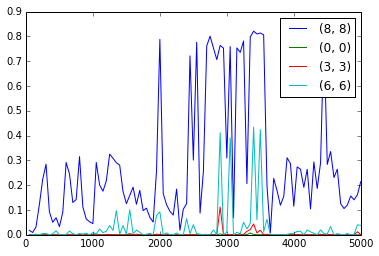

In [19]:
plot_scores()

## Visualization

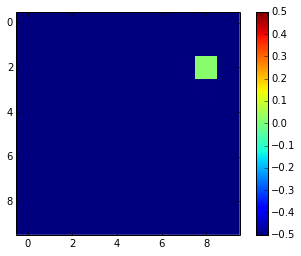

In [138]:

from ipywidgets import widgets, interact

def make_plot(i):
    (loc, im) = (start_locs[i], ims[i])
    grid = np.ones((H, W)) * -1.
    grid[loc] = im
    imshow(grid, interpolation='none', vmin=-.5, vmax=.5)
    colorbar()

interact(make_plot, i=(0,len(ims),1))


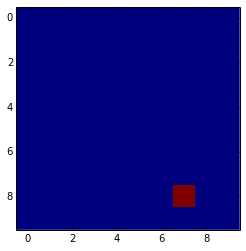

qvals [ 47.99788916  52.20889229  47.69676138  47.72885463]
p [ 0.01430037  0.96419043  0.01058204  0.01092716]
1


KeyboardInterrupt: 

In [100]:
task = test_tasks[3]
print task
task.reset()
while not task.is_end():
    imshow(task.curr_state[0], interpolation='none')
    show()
#     action = dqn.get_action(task.curr_state, method='eps-greedy', epsilon=0., valid_actions=task.valid_actions)
    action = dqn.get_action(task.curr_state, method='softmax', temperature=1e-2, valid_actions=task.valid_actions)
    print action
    sys.stdout.flush()
    task.step(action)
    time.sleep(0.5)
    clear_output()

In [102]:
reward_stochastic(dqn, task, gamma=0.9,num_trials=100, tol=tol, method='eps-greedy', epsilon=0.)

0.31843645660734682